# Práctica minería de texto
# Alumnos:
> Sergio Muñoz González

> Miguel Maquedano Tirado

# MODELO NO DEEP 

### Importación de modulos y definición de funciones

In [ ]:
#Importar paqutes necesarios
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


from string import punctuation

from nltk.corpus import stopwords

%matplotlib inline

In [3]:
COLAB = True
if COLAB:
    %tensorflow_version 1.x
    

TensorFlow is already loaded. Please restart the runtime to change versions.


In [4]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1JvZ9pUCtoratPkhAWUz-ERJVWyYbAeX0',
                                        dest_path="./precision_medicine.zip", unzip=True)

Unzipping...Done.


### Carga de datos

In [2]:
#Señalizar directorios y archivos
files = [('Alzheimer_abstracts.tsv', 'Alzheimer'),
         ('Bladder_Cancer_abstracts.tsv', 'Bladder Cancer'),
         ('Breast_Cancer_abstracts.tsv', 'Breast Cancer'),
         ('Cervical_Cancer_abstracts.tsv', 'Cervical Cancer'),
         ('negative_abstracts.tsv', 'Negative'),]

input_folder = './precision_medicine/'

In [3]:
#Definir función de carga
def load_file(file_name):
    with open(file_name) as f:
        examples = []
        content = f.readlines()
        for l in content:
            aux = l.split('\t')
            examples.append((aux[0], (' '.join(aux[1:])).replace('\n', ' ')))
        return examples

In [4]:
#Cargar textos en 'narratives' y etiquetas en 'labels'
narratives = []
labels = []
for f,label in files:
    aux = load_file(input_folder + f)
    narratives.extend([x[1] for x in aux])
    labels.extend(len(aux)*[label])

labels = np.array(labels)

In [5]:
#Comprobar longuitudes de los arrays de abstracts y etiquetas
print('Narratives number: ' + str(len(narratives)))
print('Labels number: ' + str(len(labels)))  

Narratives number: 5000
Labels number: 5000


In [6]:
#Imprimir una etiqueta con su abstract
print(labels[555])
narratives[555]

Alzheimer


"[Multifunctional Roles of APOE in Alzheimer's Disease Pathogenesis]. Numerous epidemiological studies have shown that the apolipoprotein E gene (APOE) is a strong genetic risk factor for Alzheimer's disease (AD) among people from various ethnic backgrounds. ApoE occurs as three isoforms that differ at two amino acids residues (112 and 158): ApoE epsilon2, epsilon3, and epsilon4. The epsilon4 allele is responsible for a genetic predisposition to AD, increasing the risk of AD by approximately 4-fold compared to the common epsilon3 allele. In contrast, the epsilon2 allele shows a protective effect against AD. APOE epsilon4 is known to affect the age at onset of AD in a dose-dependent manner. In addition to the role of genetic risk, increasing evidence suggests that the substantial effects of APOE genotypes on cognitive function, imaging and biomarker findings, have been reported in cognitively normal individuals in an age-dependent manner. A high frequency of amyloid deposition among cog

### Preprocesamiento y codificación con TF-IDF

#### Limpieza

Procedemos en primer lugar a eliminar todos los caracteres que correspondan a números.

In [7]:
#Limpiar números
narratives_no_numbers = []

for x in range(0,len(narratives)):
    output=''.join(c for c in narratives[x] if not c.isdigit())
    narratives_no_numbers.append(output)

Tras haber limpiado los números podemos proceder a limpiar la puntuación

In [8]:
#Limpiar puntuación
narratives_clean = []

for x in range(0,len(narratives_no_numbers)):
    output=''.join(c for c in narratives_no_numbers[x] if c not in punctuation)
    narratives_clean.append(output)

Podemos observar como ha quedado el resultado tras el preprocesamiento

In [9]:
#Imprimir una etiqueta con su abstract limpiado
print(labels[555])
narratives_clean[555]

Alzheimer


'Multifunctional Roles of APOE in Alzheimers Disease Pathogenesis Numerous epidemiological studies have shown that the apolipoprotein E gene APOE is a strong genetic risk factor for Alzheimers disease AD among people from various ethnic backgrounds ApoE occurs as three isoforms that differ at two amino acids residues  and  ApoE epsilon epsilon and epsilon The epsilon allele is responsible for a genetic predisposition to AD increasing the risk of AD by approximately fold compared to the common epsilon allele In contrast the epsilon allele shows a protective effect against AD APOE epsilon is known to affect the age at onset of AD in a dosedependent manner In addition to the role of genetic risk increasing evidence suggests that the substantial effects of APOE genotypes on cognitive function imaging and biomarker findings have been reported in cognitively normal individuals in an agedependent manner A high frequency of amyloid deposition among cognitively normal aged individuals carrying 

#### Partición

Los datos son partidos en un volumen 70-30 para el entrenamiento y la prueba respectivamente.

In [10]:
#Paticionar los datos
narratives_tr, narratives_te, y_tr, y_te = train_test_split(narratives_clean,labels,test_size=0.3,random_state=1)

#### Tokenización

En primer lugar es necesario obtener las _stopwords_ o palabras que no tienen ningún valor de cara a nusetro problema, tales como adverbios o preposiciones.

In [11]:
#Obtener stopwords
mystopwords = stopwords.words("english")

En vez de usar el _tokenizer_ por defecto de Sklearn crearemos uno propio que nos permita usar _lemmatizing_ para reducir nuestro vocabulario.

In [12]:
#Crear tokenizador con lemmatizing
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self,doc):
        return[self.wnl.lemmatize(t) for t in word_tokenize(doc)]

Usaremos el comando **TfidfVectorizer** que equivale a usar un vectorizador seguido de un transformador para obtener la matyriz TF-IDF.

In [13]:
#Tokenización y codificación
tfidf = TfidfVectorizer(max_features=1000, stop_words=mystopwords, tokenizer=LemmaTokenizer())
tfidf.fit(narratives_tr)

TfidfVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<__main__.LemmaTokenizer object at 0x7fa0dc752e50>)

Los paraámetros utilizados para **TfidfVectorizer** son los siguientes:
>**max_features** - Hace referencia a solo obtener las 1000 primeras palabras con un mejor peso.  
**stop_words** - Hace referencia a que _stopwords_ usar, en este caso usamos el conjunto de _stopwords_ en inglés del paquete nltk.  
**tokenizer** - Es el parámetro que permite ignorar el _tokenizer_ por defecto de la función y usar el creado por nosotrso previamente.

In [14]:
#tfidf.get_feature_names()

In [15]:
tfidf_tr = tfidf.transform(narratives_tr)
tfidf_te = tfidf.transform(narratives_te)

In [16]:
#print(tfidf_tr)

### NLP de alto nivel

#### Regresión losgística

En primer lugar pobaremos un modelo basado en regresión logística. Empezaremos usando los parámaetros por defecto.

In [93]:
# Model
model = LogisticRegression()

#Fitting
model.fit(tfidf_tr, y_tr)

LogisticRegression()

Es importante observar los siguientes valores por defecto:
>**C** - Indica la fuerza de la regularización, cuanto más pequeño es más estricto el proceso de regularización, el valor por defecto es 1.  
**penalty** - Indica el método de regularización aplicado, el valor por defecto es l2.  

In [94]:
#Score
model.score(tfidf_tr, y_tr), model.score(tfidf_te, y_te)

(0.9288571428571428, 0.8646666666666667)

Confusion matrix for logistic regression:
Training data
Test data


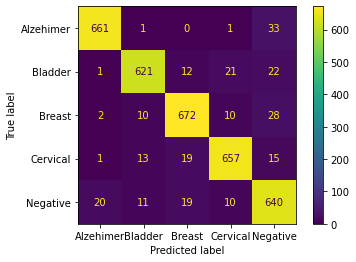

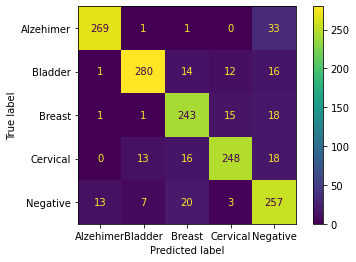

In [68]:
#Confusion matrix
print('Confusion matrix for logistic regression:')

#Training data
print('Training data')
labels_tags = ['Alzehimer','Bladder','Breast','Cervical','Negative']
plot_confusion_matrix(model,tfidf_tr, y_tr,display_labels=labels_tags)

#Test data
print('Test data')
plot_confusion_matrix(model,tfidf_te, y_te,display_labels=labels_tags)

Como podemos ver los resultados son buenos. Cabe destacar que hay una mejora respecto a los resultados para este mismo modelo en el cuaderno original, podemos atribuir esta mejora a haber construido un mejor vocabulario al incorporar técnicas como _lemmatization_. 

Parece haber un poco de overfitting, podemos empezar reduciendo este overfitting cambiando el método de regularización desde l2 a l1

In [133]:
# Model
model = LogisticRegression(penalty='l1', solver='liblinear')

#Fitting
model.fit(tfidf_tr, y_tr)

LogisticRegression(penalty='l1', solver='liblinear')

In [134]:
#Score
model.score(tfidf_tr, y_tr), model.score(tfidf_te, y_te)

(0.9162857142857143, 0.896)

In [ ]:
#Confusion matrix
print('Confusion matrix for logistic regression:')

#Training data
print('Training data')
labels_tags = ['Alzehimer','Bladder','Breast','Cervical','Negative']
plot_confusion_matrix(model,tfidf_tr, y_tr,display_labels=labels_tags)

#Test data
print('Test data')
plot_confusion_matrix(model,tfidf_te, y_te,display_labels=labels_tags)

Como podemos ver hay una pequeña mejora en la precisión del modelo, sin embargo podemos usar _grid search_ para encontrar un mejor valor de C y mejorar el modelo aun más.

In [170]:
# Model
model = LogisticRegression(penalty='l1', solver='liblinear')
grid_values = {'C':[1.1,1.2,1.3,1.4,1.5]}
grid_search_model = GridSearchCV(model, param_grid=grid_values,scoring='accuracy')

#Fitting
grid_search_model.fit(tfidf_tr, y_tr)

GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': [1.1, 1.2, 1.3, 1.4, 1.5]}, scoring='accuracy')

In [171]:
#Score

grid_search_model.score(tfidf_tr, y_tr), grid_search_model.score(tfidf_te, y_te)

(0.9228571428571428, 0.9006666666666666)

Confusion matrix for logistic regression:
Training data
Test data


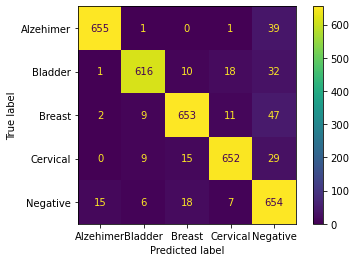

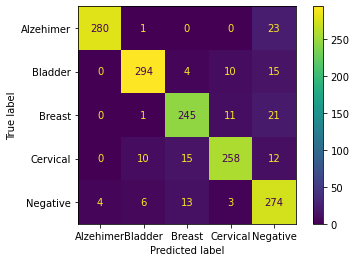

In [172]:
#Confusion matrix
print('Confusion matrix for logistic regression:')

#Training data
print('Training data')
labels_tags = ['Alzehimer','Bladder','Breast','Cervical','Negative']
plot_confusion_matrix(grid_search_model,tfidf_tr, y_tr,display_labels=labels_tags)

#Test data
print('Test data')
plot_confusion_matrix(grid_search_model,tfidf_te, y_te,display_labels=labels_tags)

Al encontrar el mejor valor de C conseguimos mejorar la precisión del modelo un poco más.

#### Clasificador MLP

Podemos usar una red neural estrecha de dos capas y observar sus resultados

In [188]:
#Model
model = MLPClassifier(verbose=False, hidden_layer_sizes=(2,),random_state=0)

#Fitting
model.fit(tfidf_tr, y_tr)

MLPClassifier(hidden_layer_sizes=(2,), random_state=0)

In [189]:
#Score
model.score(tfidf_tr, y_tr), model.score(tfidf_te, y_te)

(0.9151428571428571, 0.786)

Confusion matrix for MLP:
Training data
Test data


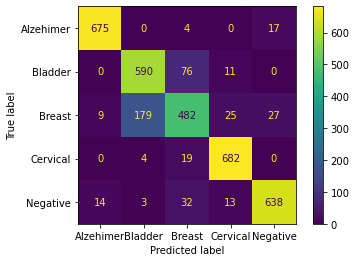

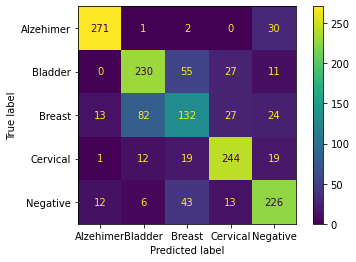

In [22]:
#Confusion matrix
print('Confusion matrix for MLP:')

#Training data
print('Training data')
plot_confusion_matrix(model,tfidf_tr, y_tr,display_labels=labels_tags)

#Test data
print('Test data')
plot_confusion_matrix(model,tfidf_te, y_te,display_labels=labels_tags)

Como podemos observar los datos obtenidos no están mal y de hecho si los comparamos con los datos originales del cuaderno de partida la mejora en el preprocesamiento ha tenido un gran efecto.  
Podemos usar _grid_search_ para encontrar los mejores parámetros para este clasificador:

In [185]:
#Model
model = MLPClassifier(verbose=False, hidden_layer_sizes=(2,),random_state=0)

grid_values = {'alpha':np.arange(0.0001,0.01,0.00495),}
grid_search_model = GridSearchCV(model, param_grid=grid_values,scoring='accuracy')

#Fitting
grid_search_model.fit(tfidf_tr, y_tr)#Score

grid_search_model.score(tfidf_tr, y_tr), grid_search_model.score(tfidf_te, y_te)

GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(2,), random_state=0),
             param_grid={'alpha': array([0.0001 , 0.00505])},
             scoring='accuracy')

In [186]:
#Score
grid_search_model.score(tfidf_tr, y_tr), grid_search_model.score(tfidf_te, y_te)

(0.9154285714285715, 0.7913333333333333)

Confusion matrix for logistic regression:
Training data
Test data


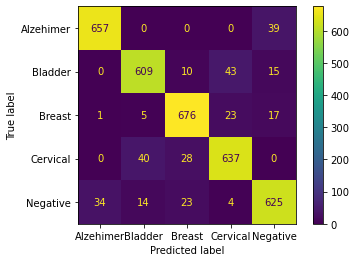

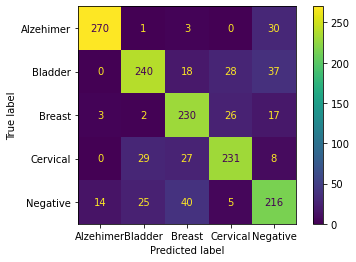

In [187]:
#Confusion matrix
print('Confusion matrix for logistic regression:')

#Training data
print('Training data')
labels_tags = ['Alzehimer','Bladder','Breast','Cervical','Negative']
plot_confusion_matrix(grid_search_model,tfidf_tr, y_tr,display_labels=labels_tags)

#Test data
print('Test data')
plot_confusion_matrix(grid_search_model,tfidf_te, y_te,display_labels=labels_tags)

Conseguimos una pequeña mejora como consecuencia de reducir _overfitting_

#### Random forest



Los modelos de _random  forest_ son una combinación de árboles predictores en la que cada árbol depende de los valores de un vector aleatorio probado independientemente y con la misma distribución para cada uno de estos.

Empezamos construyendo un clasificadorrandom forestcon todas las opcio-nes por defecto esto significa:
>**max_depth** - Se encarga de controlar la profundidad de los árboles generados, su valor por defecto es profundizar en el árbol hasta que este solotiene hojas puras que solo contienen una clase.  
**n_estimators** - Se encarga de controlar el número de árboles que se crean, por defctos son 100.

In [23]:
#Model
model = RandomForestClassifier(random_state=0)

#Fitting
model.fit(tfidf_tr, y_tr)

RandomForestClassifier(random_state=0)

In [24]:
#Score
model.score(tfidf_tr, y_tr), model.score(tfidf_te, y_te)

(0.9908571428571429, 0.91)

Confusion matrix for random forest:
Training data
Test data


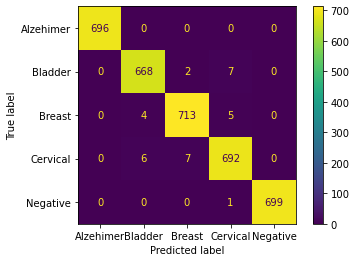

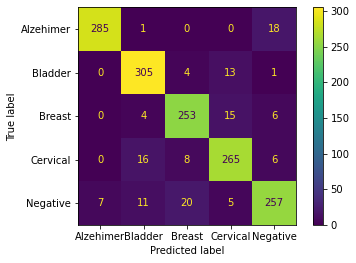

In [25]:
#Confusion matrix
print('Confusion matrix for random forest:')

#Training data
print('Training data')
plot_confusion_matrix(model,tfidf_tr, y_tr,display_labels=labels_tags)

#Test data
print('Test data')
plot_confusion_matrix(model,tfidf_te, y_te,display_labels=labels_tags)

Parece ser que hay _overfitting_ por lo que vamos a realizar un análisis para hacer un _prunning_ del modelo. Limitar el crecimiento de los árboles o _prunning_ es un método habitual para evitar el _overfitting_ en esta clase de métodos.

Usando un bucle podemos obtener las precisiones de varios clasificadores _random forest_ en función de la profundidad de árbol, con el objetivo de encontrar la profundidad óptima para nuestro modelo.

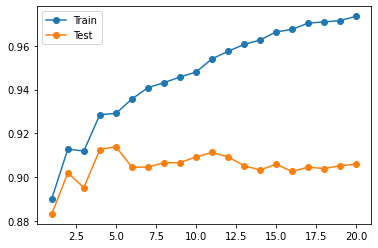

In [26]:
#Loop to detect best tree deep
values = [i for i in range(1,21)]
train_acc = []
test_acc = []

for i in values:
    model = RandomForestClassifier(max_depth=i,random_state=0)
    model.fit(tfidf_tr, y_tr)
    train_res = model.score(tfidf_tr, y_tr)
    test_res = model.score(tfidf_te, y_te)
    train_acc.append(train_res)
    test_acc.append(test_res)

plt.plot(values, train_acc,'-o',label='Train')
plt.plot(values, test_acc,'-o',label='Test')
plt.legend()
plt.show()

A profundidad 5 el test alcanza su mejor resultado, por lo que podemos volver areentrenar el modelo para ver si conseguimos reducir el _overfitting_.

In [27]:
#Model
model = RandomForestClassifier(random_state=0, max_depth=5)

#Fitting
model.fit(tfidf_tr, y_tr)

RandomForestClassifier(max_depth=5, random_state=0)

In [28]:
#Score
model.score(tfidf_tr, y_tr), model.score(tfidf_te, y_te)

(0.9291428571428572, 0.914)

Confusion matrix for random forest:
Training data
Test data


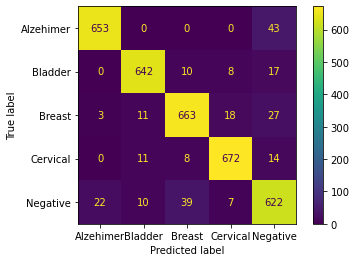

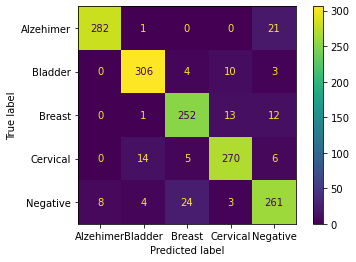

In [29]:
#Confusion matrix
print('Confusion matrix for random forest:')

#Training data
print('Training data')
plot_confusion_matrix(model,tfidf_tr, y_tr,display_labels=labels_tags)

#Test data
print('Test data')
plot_confusion_matrix(model,tfidf_te, y_te,display_labels=labels_tags)

Como podemos observar al limitar el crecimiento de los árboles conseguimos mejorar ligeramente la precisión del modelo.

#### Decison trees

Los clasificadores de árboles de decisión son similares a los _random forest_  ya que van formando hojas o ramas en función de las clasificaciones que van realizando.  
Al igual que en caso anterior podemos usar los parámetros por defecto del modelo para obtener una precisión base, los parámetros deeste clasificador son muy parecidos a los del _random forest_.

In [30]:
#Model
model = DecisionTreeClassifier(random_state=0)

#Fitting
model.fit(tfidf_tr, y_tr)

DecisionTreeClassifier(random_state=0)

In [31]:
#Score
model.score(tfidf_tr, y_tr), model.score(tfidf_te, y_te)

(0.9908571428571429, 0.882)

Confusion matrix for random forest:
Training data
Test data


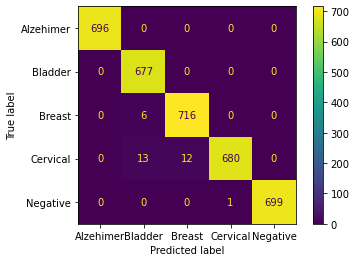

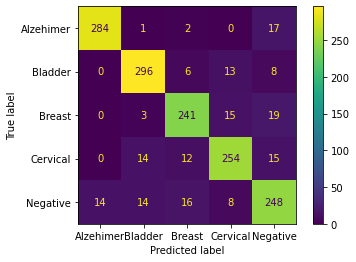

In [32]:
#Confusion matrix
print('Confusion matrix for random forest:')

#Training data
print('Training data')
plot_confusion_matrix(model,tfidf_tr, y_tr,display_labels=labels_tags)

#Test data
print('Test data')
plot_confusion_matrix(model,tfidf_te, y_te,display_labels=labels_tags)

Al igual que en el caso anterior parece existir _overfitting_, por ello podemos volver a realizar un análisis para detectar la mejor profundidad de árbol:

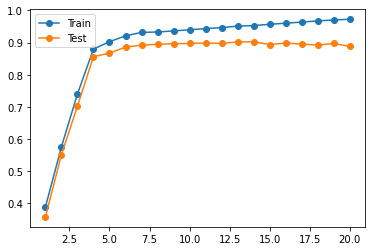

In [33]:
#Loop to detect best tree deep
values = [i for i in range(1,21)]
train_acc = []
test_acc = []

for i in values:
    model = DecisionTreeClassifier(max_depth=i,random_state=0)
    model.fit(tfidf_tr, y_tr)
    train_res = model.score(tfidf_tr, y_tr)
    test_res = model.score(tfidf_te, y_te)
    train_acc.append(train_res)
    test_acc.append(test_res)

plt.plot(values, train_acc,'-o',label='Train')
plt.plot(values, test_acc,'-o',label='Test')
plt.legend()
plt.show()

Como podemos ver en este caso la profundidad 14 es la óptima de las obtenidas, por loque podemos rentrenar el modelo con este nuevo parámetro para intentar mejorar la precisión:

In [56]:
#Model
model = DecisionTreeClassifier(random_state=0,max_depth=14)

#Fitting
model.fit(tfidf_tr, y_tr)

DecisionTreeClassifier(max_depth=14, max_features=500, random_state=0)

In [57]:
#Score
model.score(tfidf_tr, y_tr), model.score(tfidf_te, y_te)

(0.958, 0.8953333333333333)

Confusion matrix for random forest:
Training data
Test data


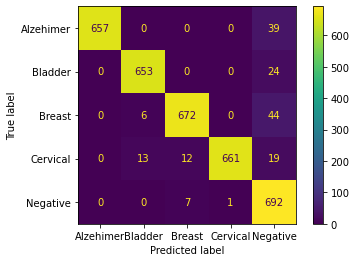

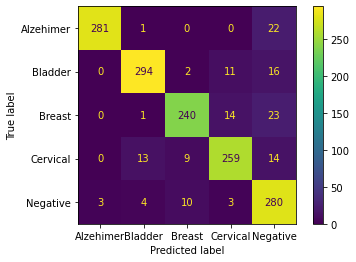

In [36]:
#Confusion matrix
print('Confusion matrix for random forest:')

#Training data
print('Training data')
plot_confusion_matrix(model,tfidf_tr, y_tr,display_labels=labels_tags)

#Test data
print('Test data')
plot_confusion_matrix(model,tfidf_te, y_te,display_labels=labels_tags)

Como podemos ver al igual que en el caso de _random forest_ podemos reducir el _overfitting_ y aumentar ligeramente la precisión del modelo.

#### K-Neighbours

Podemos usar un clasificador basado en K-Neighbours mediante la función KNeighborsClassifier de from Sklearn, el principal parámetro de este clasificador es:

>**n_neighbors** - Indica el número de vecinos que el clasificador usa para sus _queries_. 

In [193]:
#Model
model = KNeighborsClassifier()

#Fitting
model.fit(tfidf_tr, y_tr)

KNeighborsClassifier()

In [194]:
#Score
model.score(tfidf_tr, y_tr), model.score(tfidf_te, y_te)

(0.7802857142857142, 0.6693333333333333)

Confusion matrix for random forest:
Training data
Test data


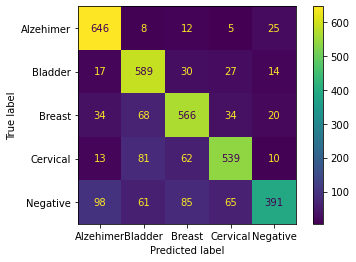

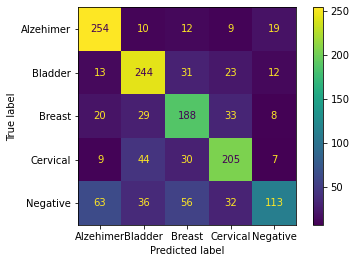

In [195]:
#Confusion matrix
print('Confusion matrix for random forest:')

#Training data
print('Training data')
plot_confusion_matrix(model,tfidf_tr, y_tr,display_labels=labels_tags)

#Test data
print('Test data')
plot_confusion_matrix(model,tfidf_te, y_te,display_labels=labels_tags)

No son muy buenos resultados, podemos intentar optimizarlos viendo como el número de vecionos afecta a la precisión: 

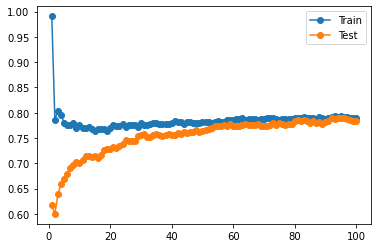

In [201]:
#Loop to detect best tree deep
values = [i for i in range(1,101)]
train_acc = []
test_acc = []

for i in values:
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(tfidf_tr, y_tr)
    train_res = model.score(tfidf_tr, y_tr)
    test_res = model.score(tfidf_te, y_te)
    train_acc.append(train_res)
    test_acc.append(test_res)

plt.plot(values, train_acc,'-o',label='Train')
plt.plot(values, test_acc,'-o',label='Test')
plt.legend()
plt.show()

Como podemos ver a bajos niveles de vecinos como el inicial (n_neighbors=5) existe un tremendo _overfitting_ el cual podemos ir reduciendo, aumentando el número de vecinos. En torno a 95 vecinos la precisión del modelo para los datos de prueba se equilibra con la de los datos de entrenamiento y se elimina el _overfitting_ existente.

Podemos reentrenar el modelo con estos resultados y ver como mejora la calidad:

In [203]:
#Model
model = KNeighborsClassifier(n_neighbors=95)

#Fitting
model.fit(tfidf_tr, y_tr)

KNeighborsClassifier(n_neighbors=95)

In [204]:
#Score
model.score(tfidf_tr, y_tr), model.score(tfidf_te, y_te)

(0.7928571428571428, 0.79)

Confusion matrix for random forest:
Training data
Test data


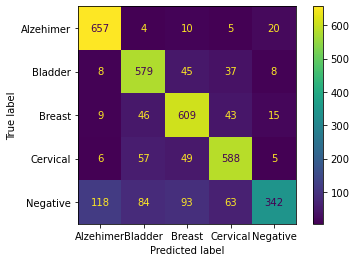

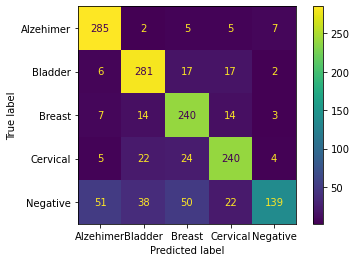

In [205]:
#Confusion matrix
print('Confusion matrix for random forest:')

#Training data
print('Training data')
plot_confusion_matrix(model,tfidf_tr, y_tr,display_labels=labels_tags)

#Test data
print('Test data')
plot_confusion_matrix(model,tfidf_te, y_te,display_labels=labels_tags)

Como podemos observar hemos mejorado considerablemente los resultados.

### Anexo de resultados

#### Lista de técnicas de preprocesamiento utilizadas:
* Limpieza de números.
* Limpieza de símbolos de puntuación.
* Obtención de _stopwords_ mediante el paquete nltk.
* Conversión de palabras a minúsculas, esto es realizado por el propio tokenizator.
* Lemmatization usando WordNetLemmmatizer del paquete nltk, se define para usar dentro del tokenizador personalizado.

#### Características de la tokenización y la vectorización

* Creación de tokenizador personalizado
* Tokenización y vectorización TF-IDF acopladas usando el comando TfidfVectorizer de sklearn 

#### Resultados de modelos

| MODELO | Precisión en training | Precisón en test |  
| ---------------- | --------------------- | --------|  
Regresión logística por defecto | 0.92885 | 0.86466 |
Regresión logística con L1 | 0.91628 | 0.89600  |
Regresión logística con L1 y C ajustado | 0.92285 | 0.90066
_Random forest_ por defecto | 0.99085 | 0.91000
_Random forest_ con _pruning_ | 0.92914 | 0.91400
_Decision tree_ por defecto | 0.99085 | 0.88200
_Decision tree_ con _pruning_ | 0.95800 | 0.89533
MLP por defecto | 0.91514 | 0.79133
MLP optimizado con _grid search_ | 0.91542 | 0.79133
K-Neighbours por defecto | 0.78028 | 0.66933
K-Neighbours optimizado | 0.79285 | 0.79000

# MODELO DEEP

### Importación de modulos y definición de funciones

In [1]:
# Extendido de https://raw.githubusercontent.com/fchollet/keras/master/examples/imdb_lstm.py
# y de
# http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
#
# por Manuel Sánchez-Montañés

import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.ticker import MaxNLocator

from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM,GRU, Dropout
from keras.layers.embeddings import Embedding
from keras import regularizers
from keras.constraints import UnitNorm
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances
from sklearn.preprocessing import LabelEncoder

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool, LabelSet, ColumnDataSource, Range1d
from bokeh.plotting import figure, show, output_notebook

from gensim.models.word2vec import Word2Vec # word2vec model gensim class
from gensim.models.doc2vec import TaggedDocument

from IPython.display import SVG, clear_output, display
from keras.utils.vis_utils import model_to_dot
import pickle
import urllib

# fix random seed for reproducibility
np.random.seed(7)

%matplotlib inline

In [2]:
def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

def visualiza_procesamiento_LSTM(seq, y, text, interpretacion_sentimientos, model2, alpha=0.2):
    plt.figure(figsize=(15,15))
    plt.plot(sals_finales_pca_tr[inds_0,0],
             sals_finales_pca_tr[inds_0,1], '.r', alpha=alpha/2)
    plt.plot(sals_finales_pca_tr[inds_0[-1],0],
             sals_finales_pca_tr[inds_0[-1],1], '.r',
             label="Sentimiento "+interpretacion_sentimientos[0])
    plt.plot(sals_finales_pca_tr[inds_1,0],
             sals_finales_pca_tr[inds_1,1], '.', alpha=alpha)
    plt.plot(sals_finales_pca_tr[inds_1[-1],0],
             sals_finales_pca_tr[inds_1[-1],1], '.b',
             label="Sentimiento "+interpretacion_sentimientos[1])
    text_aux = [int2word[x] for x in seq]
    aux = pca.transform(model2.predict(np.array([seq]))[0])
    plt.plot(aux[:,0], aux[:,1])
    for x,w in zip(aux,text_aux):
        plt.text(x[0],x[1],w)
    plt.plot(aux[0,0],aux[0,1],'og',markersize=40,alpha=0.5)
    plt.plot(aux[0,0],aux[0,1],'og',label="Start")
    plt.plot(aux[-1,0],aux[-1,1],'oy',markersize=40,alpha=0.5)
    plt.plot(aux[-1,0],aux[-1,1],'oy',label="End")
    plt.title("{} \n Sentimiento={} ({})".format(text, y,interpretacion_sentimientos[y]),
              fontsize=16)
    plt.legend(fontsize=14);

In [3]:
COLAB = True
if COLAB:
    %tensorflow_version 1.x
    

TensorFlow is already loaded. Please restart the runtime to change versions.


In [4]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1JvZ9pUCtoratPkhAWUz-ERJVWyYbAeX0',
                                        dest_path="./precision_medicine.zip", unzip=True)

Unzipping...Done.


### Carga de datos

In [5]:
files = [('Alzheimer_abstracts.tsv', 'Alzheimer'),
         ('Bladder_Cancer_abstracts.tsv', 'Bladder Cancer'),
         ('Breast_Cancer_abstracts.tsv', 'Breast Cancer'),
         ('Cervical_Cancer_abstracts.tsv', 'Cervical Cancer'),
         ('negative_abstracts.tsv', 'Negative'),]

input_folder = './precision_medicine/'

In [6]:
def load_file(file_name):
    with open(file_name) as f:
        examples = []
        content = f.readlines()
        for l in content:
            aux = l.split('\t')
            examples.append((aux[0], (' '.join(aux[1:])).replace('\n', ' ')))
        return examples

In [7]:
narratives = []
labels = []
for f,label in files:
    aux = load_file(input_folder + f)
    narratives.extend([x[1] for x in aux])
    labels.extend(len(aux)*[label])


### Codificacion del vector labels 

In [8]:
le = LabelEncoder()
labels = le.fit_transform(labels)
labels

array([0, 0, 0, ..., 4, 4, 4])

### Limpieza del vocabulario

En este caso nosotros eliminamos los numeros arabigos como primer paso de limpieza

In [9]:
narratives_no_numbers = []
for x in  range(0,len(narratives)):
    output=''.join(c for c in  narratives[x] if not c.isdigit ())
    narratives_no_numbers.append(output)

In [10]:
from  string  import  punctuation
narratives_clean = []
for x in  range(0,len(narratives_no_numbers)):
    output=''.join(c for c in  narratives_no_numbers[x] if c not in  punctuation)
    narratives_clean.append(output)

In [11]:
narratives_lowerc = []
for x in  range(0,len(narratives_clean)):
    output=narratives_clean[x].lower()
    narratives_lowerc.append(output)

### Split de los datasets

In [32]:
narratives_tr , narratives_te , y_train , y_test =  train_test_split(
    narratives_lowerc ,labels ,test_size =0.25, random_state =1)
len(narratives_tr)

3750

### Tokenización

In [13]:
top_words = 5000

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(narratives_tr)

In [14]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(narratives_tr)]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(narratives_te)]

In [15]:
len(X_train)

3750

### Indexación

In [16]:
# Índices mínimo y máximo en training y test sin meter aún padding, que tendrá índice 0
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 4999, 1, 4999)

In [17]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [18]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 cancer
13 were
14 is
15 patients
16 that
17 as
18 by
19 on


### Padding

In [19]:
# truncate and pad input sequences
max_review_length = 250
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3750, 250)
Los códigos de palabras van de 0 a 4999


In [20]:
X_train_pad[3]

array([ 334,   80,    6, 3616,    4,  457,   26,   12,   15,    9,  222,
        196,  483,    8, 1463,   25,  277,   56,   40,  423,    3,  109,
          4,    2,  231, 3616,   10,   26,   12,   15,    9,   35,  719,
        196,  483,  254,    6,    3,  441,   91,  591,    3,  195,    4,
        222,  196,  483,    2,   53,   55, 1842, 4856,  930,    7,    5,
       1601,   17,    8,  224, 1742,    6,  106, 3617,    4,    2,  358,
         75,   14,  553,  957,    7,   25,    3,  166,   39,    3,  195,
          4,    2,    5,    3,  369,    4, 3616,    6,   26,   12,   15,
          6,   69,   25,   21,   61, 1108, 2222,    5, 1056,   31,    2,
       1463,   65,    5,  156,   26,   12,   15,    7,  976,   77,  333,
          3, 2365, 1324,    5,    3, 2674, 1960,  173,   13,  819,    7,
        340,    3,  875, 1355,  996,    4,    3,  195,    4,    2,    5,
         11,  521,   17,    3, 1355,  996,  391,    3, 1355,  996,   11,
       1232,   17,   29,  389,  224,  146, 1585, 17

### Construcción del modelo

In [21]:
#rnn = LSTM
rnn = GRU
p = 0.5 # 0.2, 0.3, ...
set_dropout=True
embedding_vector_length = 200
model = Sequential()
model.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.0005), # regularización (intenta poner a cero componentes)
#                    embeddings_constraint=UnitNorm(axis=1),
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
#model.add(BatchNormalization())

# dropout: capa que intenta minimizar el sobreajuste
if set_dropout: # mete "ruido": con probabilidad p pone a 0 la información de la capa anterior
    model.add(Dropout(p))
    model.add(rnn(100)) # MANY TO ONE (return_sequences no es True)
    model.add(Dense(75, activation='relu'))
    model.add(Dense(5, activation='softmax')) # sigmoid porque hay 2 clases, si hay más, softmax
    model.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
                  optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
                  metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 200)          1000000   
_________________________________________________________________
dropout (Dropout)            (None, 250, 200)          0         
_________________________________________________________________
gru (GRU)                    (None, 100)               90600     
_________________________________________________________________
dense (Dense)                (None, 75)                7575      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 380       
Total params: 1,098,555
Trainable params: 1,098,555
Non-trainable params: 0
_________________________________________________________________


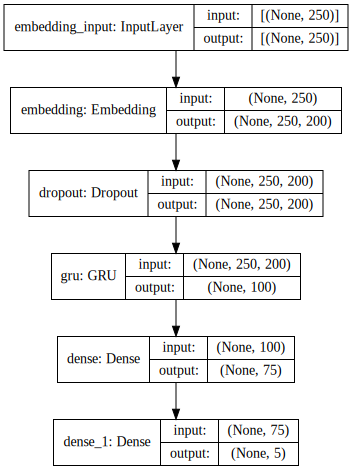

In [22]:
model.summary()
if True:
    display(SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg')))

### Reservamos, dentro del conjunto de training, un subconjunto de validación

In [24]:
# Entrenar sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.25, random_state=1)
print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)

(2812, 250) (2812,)
(938, 250) (938,)


### Entrenamiento del modelo

In [25]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

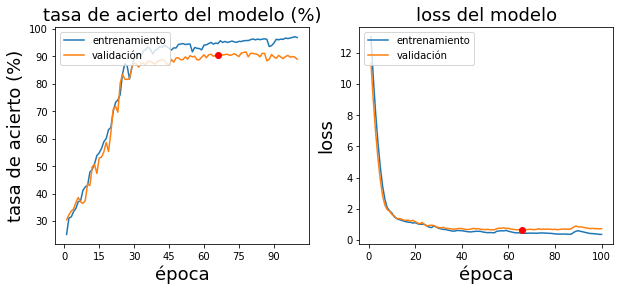

In [26]:
for e in range(nepocas):
  h = model.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
# if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [27]:
model.set_weights(best_weights)

In [28]:
scores = model.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

40/40 [==============================] - 0s 12ms/step - loss: 0.6476 - accuracy: 0.8984
Accuracy in test: 89.84%


### Análisis del embedding construido por la red neuronal</h1></font>

In [620]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model.get_weights()[0]
embedding.shape

(5000, 200)

In [622]:
most_similar_words(embedding,'a')

['best',
 'east',
 'diversion',
 'tend',
 'females',
 'epidemiology',
 'predictor',
 'it',
 'proportion',
 'diagnostic']

In [623]:
most_similar_words(embedding,'excellent')

['instruments',
 'increasing',
 'tracer',
 'mugml',
 'his',
 'ph',
 'accurate',
 'systematic',
 'feasible',
 'cutaneous']

### Nube de palabras

In [625]:
latent_dimension_x = 0
latent_dimension_y = 1

pca = PCA(n_components=3)
words_pca = pca.fit_transform(embedding)
output_notebook()
p = bp.figure(plot_width=700, plot_height=600, title="espacio de palabras",
              tools="pan,wheel_zoom,box_zoom,reset,hover",
              x_axis_label='latent dimension {}'.format(latent_dimension_x),
              y_axis_label='latent dimension {}'.format(latent_dimension_y),
              #x_axis_type=None, y_axis_type=None,
              min_border=1)
p.title.text_font_size='16pt'
p.xaxis.axis_label_text_font_style='normal'
p.xaxis.axis_label_text_font_size='16pt'
p.yaxis.axis_label_text_font_style='normal'
p.yaxis.axis_label_text_font_size='16pt'

p.xgrid.visible = False
p.ygrid.visible = False

dictf = {'x':words_pca[:,latent_dimension_x],
         'y':words_pca[:,latent_dimension_y],
         'words':[int2word[i] for i in range(len(words_pca))]}
aa = ColumnDataSource(dictf)
p.scatter(x='x', y='y', source=aa, color='black')
labels_p = LabelSet(x='x', y='y', text='words', level='glyph',
                    x_offset=5, y_offset=5, source=aa, render_mode='canvas',
                    text_color='blue', text_font_size='10pt')
p.add_layout(labels_p)

hover = p.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(p)

### Análisis de la red construida

In [638]:
model_aux = Sequential()
model_aux.add(Embedding(top_words, embedding_vector_length,
                        input_length=max_review_length))
#model_aux.add(BatchNormalization())
model_aux.add(rnn(100, return_sequences=True))
model_aux.add(Dense(75, activation = 'relu'))
model_aux.add(Dense(5, activation='softmax'))
model_aux.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [639]:
model_aux.set_weights(best_weights)
model2 = Model(inputs=model_aux.inputs, outputs=model_aux.layers[-2].output)
salidas_GRU_tr = model2.predict(X_train_pad)
salidas_GRU_tr.shape

(3750, 250, 75)

In [640]:
salidas_finales_tr = salidas_GRU_tr[:,-1,:]
salidas_finales_tr.shape

(3750, 75)

In [641]:
pca = PCA(n_components=2)
pca.fit(salidas_finales_tr)
sals_finales_pca_tr = pca.transform(salidas_finales_tr)
inds_0 = np.where(y_train==0)[0]
inds_1 = np.where(y_train==1)[0]
sals_finales_pca_tr0 = sals_finales_pca_tr[inds_0]
sals_finales_pca_tr1 = sals_finales_pca_tr[inds_1]

In [ ]:
salidas_finales_tr = salidas_LSTM_tr[:,-1,:]
salidas_finales_tr.shape

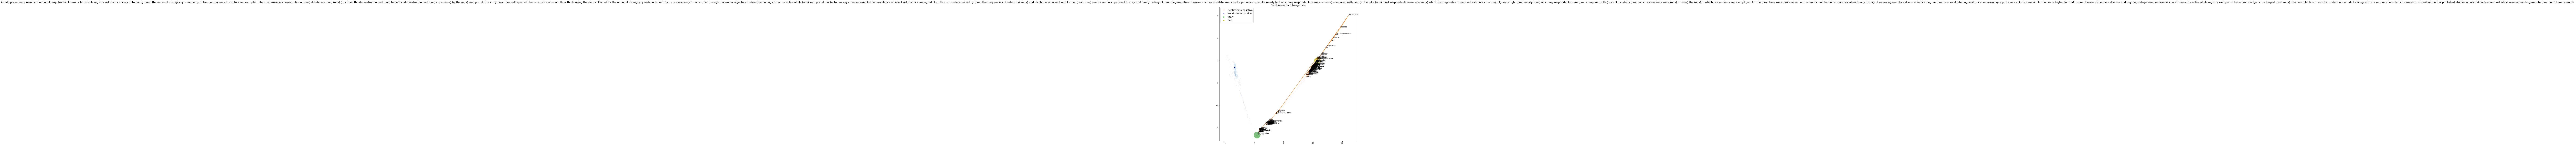

In [642]:
interpretacion_sentimientos = {0:"negativo", 1:"positivo"}
ejemplo = 5
texto = " ".join([int2word[x] for x in X_train[ejemplo]])
visualiza_procesamiento_LSTM(X_train_pad[ejemplo], y_train[ejemplo], texto,
                             interpretacion_sentimientos, model2, alpha=0.03)

### Report:Conclusiones y tablas

**Preprocesamiento**
* Tras realizar la carga de los datos y tener el conjunto X y el vector con los labels(Y),es necesario codificar las variables categoricas nominales del vector con las labels a numeros, que es lo que va a poder interpretar nuestro modelo.Por lo mencionado anteriormente realizamos una codificación númerica con el modulo LabelEncoder de sklearn.Normalmente se suele hacer un onehotencoding(para obtener las variables dummeis) para este tipo de variables nominales con mas de 2 clases(aplicando metodos como OneHotEncoder de sklearn, get_dummies de pandas o to_categorical de keras) no obstante decidimos hacer una codificacion simple(sin variables dummy, y luego en el modelo espeficiar como funcion de Loss:'Sparse categorical cross entropy'
* Seguidamente se procedio a realizar una limpieza de los textos, para normalizar y quitar caracteres no deseados.La limpieza de vocabulario para modelos deep es algo menos elaborada, ya que hay pasos que no suelen ser necesarios.Como por ejemplo la eliminación de stopwords, que para modelos deep no se elimina.O incluso simbolos de puntuacion que en ocasiones para estos modelos tampoco es requerida su limpieza.AL final la red neuronal sabrá interpretar features como las stopword de manera interna sin necesidad de que ayudemos al modelo a eliminarlas como ocurre en art of state, en el cual hay que diseñar el conjunto de features y añadir features de información externa
En primer el paso de limpieza hemos eliminado los numeros arabigos. Hemos optado por hacer eliminación de los simbolos de puntuacion inicialmente y en base a los resultados finales plantear mantenerlos en el texto.
Como ultimo paso de limpieza hemos sustituido todas las letras mayusculas a minusculas.
* Al finalizar la limpieza realizamos un split de los textos ya limpiados, generando los datasets de entrenamiento y test y sus vectores de labels respectivos.Indicamos como test_size = 0.25
* Tras haber hecho el split obteniendo los diferentes datasets con los abstracts limpiados, se llevo a cabo la tokenizacion, donde se establece el vocabulario y su tamaño, y se tokaniza , separando las palabras como unidades semanticas.Se indico topword = 5000, fijando en 5000 las palabras maximas del vocabulario.El tokenizador tiene la opción 'oov-out of vocabulary', de manrra que todas las palabras que no entren en el vocabulario por su restricción maxima de palabras, se presentaran como oov.
Cabe mencionar que probamos a seleccionar 10000 como maximo de palabras para el vocabulario, pero los modelos mostraban peores resultados que con 5000 , es por eso que 5000 fue la cifra final que seleccionamos para el vocabulario.


|TABLA PREPROCESAMIENTO|Técnicas
|:-----------------------------|--------------
|Codificacion de vector labels|Codificacion(no dummie)  con LabelEncoder de sklearn
|Eliminación de numeros arabigos|Se recorren caracteres en loop con el metodo,eliminando los numeros comprobando si son digitos con el metodo 'isdigit' 
|Eliminación de signos de puntuacion|Se recorren caracteres en un loop y se comprueba si es un simbolo de puntuación comprobando si esta en 'punctuation'
|Letras mayusculas|Las letras mayusculas se pasan a minúsculas
|Tokenizacion|Se tokeniza con un número maximo de palabras del vocabulario establecido en 5000.
|Indexación|A las palabras de los textos se las codifica con un numero de 1 a 4999.
|Padding|El la longitud deseada de los samples al hacer el padding y rellenar con 0 se establecio en 250.

**Embedding**

* El embeding se realiza en el propio modelo de la red neuronal en el cual añadimos como primera capa una capa encargada especificamente de esta tarea.El embeding aprende representacion vectoriales a partir de variables categoricas, es decir pasa de vectores de alta dimensionalidad de valores discretos de las variables categoricas condificadas(por ejemplo con one hot encoding) a vectores de baja dimensionalidad de valores continuos(float numbers) los cuales indicaran las relaciones contextuales de las palabras en el espacio vectorial del embeding .Es decir la ventaja de la codificación por embbeding es la capacidad de mantener la informacion semantica y contextual para la palabras.

|Embedding|Opciones
|:------------:|:-----------
|longitud de los vectores resultantes del embedding|150 valores
|Regularizacion norm|Se usa regularizados Lassos(L1) con valor de regularización 0.0005
|top word|Se introduce el vocabulario de 5000 palabras
|Longitud de las samples|La longitud de los input samples es de 250, la establecida por el padding previamente

**Construccion del la RNN**

Para la contrucción de la red neuronal el modelo final partimos de una capa de embedding al que entraran los input samples en los que los vectores de cada palabra en secuencias de 2509 palabras sera reducidos de 5000 dimensiones a 150.Seguidamente se añadio una capa de 100 neuronas con celda tipo GRU(compuerta reset y compuerta update) para actualizar el 'hidden state'.Se eligio GRU por que la arquitectura de este tipo de celda nos proveia de mejores resultados con el dataset y la tarea que estamos procesando.Seguidamente se añadio una capa densa de 75 neuronas con la funcion de activación relu.La capa de output es una capa de 5 neuronas, que usa la funcion de activación softmax, de manera que cada neurona devolvera la probabilidad del input de partenecer a cada una de las clases repectivamente,es decir, una neurona para cada clase.Cabe destacar que se añade regularizacion al modelo mediante dropout, estoy anulara neuronas del modelo de manera aleatoria con el fin de evitar y corregir overfitting.A mayor p de dropout, mas contundente sera la desguarizacion por este metodo y viceversa.
La arquitectura del modelo es secuencial ya que tiene en cuenta la informacion contextual, algo importante para la tarea que llevamos a cabo, en la cual el orden de la palabra es importante.
El optimizador utilizado para la red fue adam con un learning rate de 0.001
La Loss funcion usada, para penaliza la calidad de las predicciones fue sparse_categorical_crossentropy(ya que el vector con los labels,y, no esta condificado con variables dummy.
Previamente al alcanzar este modelo final se probó una red neuronal con una capa LSTM de 100 neuronas y una de 5 neuronas de output con softmax(sin la cpaa dense de 75 neuronas del moodelo final).Tambien se probo una red many to one stacked como la descrita en el modelo final , pero la capa del hidden state fue provada con celda LSTM.
Nos quedamos con la arquitectura mencionada en el modelo final, ya que fue el que mejor Accuracy y loss presentaba.
El batch size se dejo por defecto en 512 , y el número de epochs para el entrenamiento se fijo en 100,se aumento ya que con 20 epochs(el parametro por defecto) el modelo no llegaba a converger con un aprendizaje óptimo, mostrando accuracies y errores poco favorables.

|MODELO FINAL|Parámetros
|:-------------------:|:-----------------
|Tipo de celda usada|GRU
|Modelo|Secuencial
|Optimizador|Adam
|Learning rate|0.001
|Numero de epochs|100
|Batch size|512
|Capa embedding|Parametros en Tabla "embedding"
|Capa GRU|100 neuronas
|Caoa dense|75 neuronas, 'relu'
|Capa output|5 neuronas, softmax
|p-dropout|0.5

Tras realizar diversos entrenamientos con el modelo final, el accuracy que obtenemos es de ≈ 90%
En el último entrenamiento se puede ver que los resultados de acuraccy y de loss son:
> loss: 0.6476 - accuracy: 0.8984

**Nube de palabras**

Las palabras que se representan en el espacio vectorial del embeding por su relacion y parecido contextual. Las palabras mas juntas tendran mas parecido en los valores de los features de los vectores que les codifican(generados por el embeding) y tendran una relacion contextual o semántica.Hay palabras aisladas y separadas dracticamente formando grupos fuera de la gran nube central de palabras , ya que tienen unas caracteristas determinantes para la clasificacion,es decir tienen features en los vectores que hace que se esten diferenciando claramente de la mayoria de las palabras(nube central),las cuales realmente no estan determiando la clasificacion del texto en un tipo u otro.